This notebook is to document the implementation of drought deciduous only vegetation in FATES.

Issues noted so far include:
1. The biomass doesn't seem to go entirely to zero...
2. The leaf lifespan is hardwired to one year. This means that all the leaves stay on most of the time in always-wet places, which is a problem. 
3. The trigger is voumetric water content, which is an issue because 
    a) this is randomly dependant on soil texture and not a metric of soil stress
    b) it is sensitive to freezing (is that not real)
    c) it tracks the top of the soil, which is too twitchy.
4. We don't have a rainfall trigger ala CLM5. 



In [1]:
                        %matplotlib inline
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
from matplotlib import pyplot as plt
import datetime
import cartopy
import cartopy.crs as ccrs
import os.path

Then we choose which simulations to use...

In [2]:
runs = ['fates_DDT_singlepft','fates_DDT_singlepft_thr0.25','fates_DDT_singlepft_thr0.25_FFoff90',\
        'fates_DDT_singlepft_thr0.25_FFoff90_dlo' ,'fates_DDT_singlepft_thr0.25_FFoff90_dlo_term'\
       ,'fates_DDT_singlepft_thr0.25_FFoff90_dlo_morestore','fates_DDT_singlepft_thr0.25_FFoff90_dlo_morestore_dbuffer',\
       'fates_DDT_singlepft_thr0.25_FFoff90_dlo_evenmorestore_dbuffer']

Then we make an ugly list of variables to ignore (the files being large)

(n.b. does anyone know how to make this inclusive rather than exclusive? 
Reading in >10 years of 4x5 output takes nearly forever)

In [3]:
drop={'ACTUAL_IMMOB','ATM_TOPO','BCDEP','BTRAN','CBALANCE_ERROR_BGC','CBALANCE_ERROR_ED','CBALANCE_ERROR_TOTAL',
      'CWD_STOCK_COL','C_LBLAYER','C_STOMATA','DENIT','DSL','DSTDEP','DSTFLXT','EFLXBUILD','EFLX_DYNBAL',
      'EFLX_GRND_LAKE','EFLX_LH_TOT','EFLX_LH_TOT_R','EFLXBUILD','EFLX_DYNBAL','EFLX_GRND_LAKE','EFLX_LH_TOT',
      'EFLX_LH_TOT_R','ERRH2O','ERRH2OSNO','ERRSEB','ERRSOI','FCEV','FCOV','FCTR','FFIX_TO_SMINN','FGEV','FGR',
      'FGR12','FH2OSFC','FIRA','FIRA_R','FIRE','FSA','FSAT','FSDS','FSDSND','FSDSNDLN','FSDSNI','FSDSVD','FSDSVDLN',
      'FSDSVI','FSDSVILN','FSH','FSH_PRECIP_CONVERSION','FSH_G','FSH_R','FSH_RUNOFF_ICE_TO_LIQ','FSH_TO_COUPLER',
      'FSH_V','FSM','FSNO','FSNO_EFF','FSR','FSRND','FSRNDLN','FSRNI','FSRVD','FSRVDLN','FSRVI','GROSS_NMIN','H2OCAN',
      'H2OSNO_TOP','HEAT_CONTENT1','HEAT_FROM_AC','HIA','HIA_R','HIA_U','HUMIDEX','HUMIDEX_R','HUMIDEX_U',
      'ICE_CONTENT1','LAKEICEFRAC_SURF','LAKEICETHICK','LIQUID_CONTENT1','LITR1N','LITR1N_vr','LITR2N','LITR2N_vr',
      'LITR3N','LITR3N_vr','NDEP_TO_SMINN','NET_NMIN','O_SCALAR','PARVEGLN','PBOT','PCT_GLC_MEC','POTENTIAL_IMMOB',
      'QCHARGE','QDRAI','QDRAI_PERCH','QDRAI_XS','QDRIP','QFLOOD','QFLOOD','QFLX_DEW_GRND','QFLX_DEW_SNOW',
      'QFLX_EVAP_TOT','QFLX_ICE_DYNBAL','QFLX_LIQ_DYNBAL','QFLX_SNOW_DRAIN','QFLX_SNOW_DRAIN_ICE','QFLX_SUB_SNOW',
      'QH2OSFC','QICE','QICE_FRZ','QICE_MELT','QINFL','QINTR','QIRRIG','QOVER','QRGWL','QRUNOFF','QRUNOFF_ICE',
      'QRUNOFF_TO_COUPLER','QSNOCPLIQ','QSNOFRZ','QSNOFRZ_ICE','QSNOMELT','QSNOMELT_ICE','QSNO_TEMPUNLOAD',
      'QSNO_WINDUNLOAD','QSNWCPICE', 'QSOIL_ICE','SABG_PEN','SABV','SMINN','SMINN_LEACHED','SMINN_TO_PLANT',
      'SNOBCMCL','SNOBCMSL','SNOCAN','SNODSTMCL','SNODSTMSL','SNOFSRND','SNOFSRND','SNOFSRVD','SNOFSRVI',
      'SNOINTABS','SNOOCMCL','SNOOCMSL','SNOTXMASS','SNOUNLOAD','SNOW_PERSISTENCE','SNOW_SINKS','SNOW_SOURCES',
      'SOIL1N','SOIL1N_vr','SOIL2N','SOIL2N_vr','SOIL3N','SOIL3N_vr','SOILC_HR','SOILICE','SOILLIQ','SOILRESIS',
      'SOILWATER_10CM','SOM_C_LEACHED','SUPPLEMENT_TO_SMINN','SWBGT','SWBGT_U','TAUX','TAUY','TKE1','TLAKE',
      'TREFMNAV','TREFMXAV','TSOI_ICE','T_SCALAR','U10','U10_DUST','URBAN_AC','URBAN_HEAT','VOLR','VOLRMCH',
      'WASTEHEAT','WBT','WBT_R','WBT_U','W_SCALAR','ZBOT','ZWT','ZWT_PERCH'}

Read data from the archive: (but only the first couple of years for the sake of the aforementioned slowness)

In [4]:
scratch = '/glade/scratch/rfisher/'
yr='.clm2.h0.0010-01-01-00000.nc'


In [5]:
run = runs[0]
arc = scratch + 'archive/' + run + '/lnd/hist/'
f1=(arc+run+yr)
f=os.path.isfile(f1)
if(f):
  ds0 = xr.open_mfdataset([f1], drop_variables=drop, decode_times=False)
else:
  arc = scratch + run + '/run/'
  f1=(arc+run+yr)
  print(f1)
  ds0 = xr.open_mfdataset([f1], drop_variables=drop, decode_times=False)    

In [6]:
run = runs[1]
arc = scratch + 'archive/' + run + '/lnd/hist/'
f1=(arc+run+yr)
f=os.path.isfile(f1)
if(f):
  arc = scratch + 'archive/' + run + '/lnd/hist/'
  f1=(arc+run+yr)
  ds1 = xr.open_mfdataset([f1], drop_variables=drop, decode_times=False)
else:
  arc = scratch + run + '/run/'
  f1=(arc+run+yr)
  print(f1)
  ds1 = xr.open_mfdataset([f1], drop_variables=drop, decode_times=False)


In [7]:
run = runs[2]
arc = scratch + 'archive/' + run + '/lnd/hist/'
f1=(arc+run+yr)
f=os.path.isfile(f1)
if(f):
  arc = scratch + 'archive/' + run + '/lnd/hist/'
  f1=(arc+run+yr)
  ds2 = xr.open_mfdataset([f1], drop_variables=drop, decode_times=False)
else:
  arc = scratch + run + '/run/'
  f1=(arc+run+yr)
  print(f1)
  ds2 = xr.open_mfdataset([f1], drop_variables=drop, decode_times=False)  

In [8]:
run = runs[3]
arc = scratch + 'archive/' + run + '/lnd/hist/'
f1=(arc+run+yr)
f=os.path.isfile(f1)
if(f):
  arc = scratch + 'archive/' + run + '/lnd/hist/'
  f1=(arc+run+yr)
  ds3 = xr.open_mfdataset([f1], drop_variables=drop, decode_times=False)
else:
  arc = scratch + run + '/run/'
  f1=(arc+run+yr)
  print(f1)
  ds3 = xr.open_mfdataset([f1], drop_variables=drop, decode_times=False)  

In [9]:
run = runs[4]
arc = scratch + 'archive/' + run + '/lnd/hist/'
f1=(arc+run+yr)
f=os.path.isfile(f1)
if(f):
  arc = scratch + 'archive/' + run + '/lnd/hist/'
  f1=(arc+run+yr)
  ds4 = xr.open_mfdataset([f1], drop_variables=drop, decode_times=False)
else:
  arc = scratch + run + '/run/'
  f1=(arc+run+yr)
  print(f1)
  ds4 = xr.open_mfdataset([f1], drop_variables=drop, decode_times=False)  

In [10]:
run = runs[5]
arc = scratch + 'archive/' + run + '/lnd/hist/'
f1=(arc+run+yr)
f=os.path.isfile(f1)
if(f):
  arc = scratch + 'archive/' + run + '/lnd/hist/'
  f1=(arc+run+yr)
  ds5 = xr.open_mfdataset([f1], drop_variables=drop, decode_times=False)
else:
  arc = scratch + run + '/run/'
  f1=(arc+run+yr)
  print(f1)
  ds5 = xr.open_mfdataset([f1], drop_variables=drop, decode_times=False) 

In [11]:
run = runs[6]
arc = scratch + 'archive/' + run + '/lnd/hist/'
f1=(arc+run+yr)
f=os.path.isfile(f1)
if(f):
  arc = scratch + 'archive/' + run + '/lnd/hist/'
  f1=(arc+run+yr)
  ds6 = xr.open_mfdataset([f1], drop_variables=drop, decode_times=False)
else:
  arc = scratch + run + '/run/'
  f1=(arc+run+yr)
  print(f1)
  ds6 = xr.open_mfdataset([f1], drop_variables=drop, decode_times=False) 

In [12]:
run = runs[7]
arc = scratch + 'archive/' + run + '/lnd/hist/'
arc = scratch + run + '/run/'
f1=(arc+run+yr)
f=os.path.isfile(f1)

if(f):
  arc = scratch + run + '/run/'
  f1=(arc+run+yr)
  ds7 = xr.open_mfdataset([f1], drop_variables=drop, decode_times=False)
else:
  arc = scratch + 'archive/' + run + '/lnd/hist/'
  f1=(arc+run+yr)
  print(f1)
  ds7 = xr.open_mfdataset([f1], drop_variables=drop, decode_times=False)

/glade/scratch/rfisher/archive/fates_DDT_singlepft_thr0.25_FFoff90_dlo_evenmorestore_dbuffer/lnd/hist/fates_DDT_singlepft_thr0.25_FFoff90_dlo_evenmorestore_dbuffer.clm2.h0.0010-01-01-00000.nc


Then we plot a timeseries of the LAI of all global points

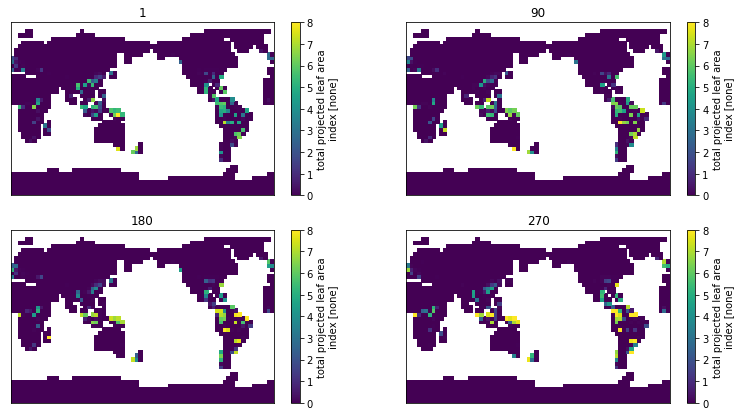

In [13]:
plt.rcParams['figure.figsize'] = [13, 7]
fig,([ax0, ax1],[ax2,ax3]) = plt.subplots(ncols=2, nrows=2)
t=ds3.SITE_COLD_STATUS.sizes['time']-365

plt1=ds4.TLAI[t+1,:,:].plot(ax=ax0)
plt2=ds4.TLAI[t+90,:,:].plot(ax=ax1)
plt3=ds4.TLAI[t+180,:,:].plot(ax=ax2)
plt4=ds4.TLAI[t+270,:,:].plot(ax=ax3)

ax0.set_title('1')
ax1.set_title('90')
ax2.set_title('180')
ax3.set_title('270')

ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)

plt1.set_clim(0, 8)
plt2.set_clim(0, 8)
plt3.set_clim(0, 8)
plt4.set_clim(0, 8)

plt.savefig('../figs/DDT_TLAI_dlo_noterm.png')

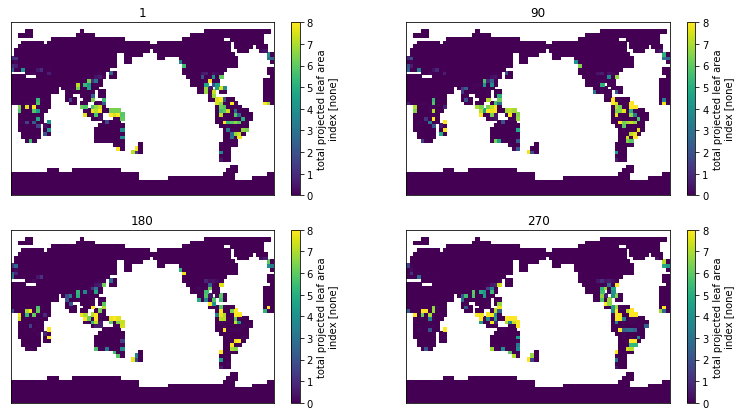

In [14]:
plt.rcParams['figure.figsize'] = [13, 7]
fig,([ax0, ax1],[ax2,ax3]) = plt.subplots(ncols=2, nrows=2)
t=ds4.SITE_COLD_STATUS.sizes['time']-365

plt1=ds5.TLAI[t+1,:,:].plot(ax=ax0)
plt2=ds5.TLAI[t+90,:,:].plot(ax=ax1)
plt3=ds5.TLAI[t+180,:,:].plot(ax=ax2)
plt4=ds5.TLAI[t+270,:,:].plot(ax=ax3)

ax0.set_title('1')
ax1.set_title('90')
ax2.set_title('180')
ax3.set_title('270')

ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)

plt1.set_clim(0, 8)
plt2.set_clim(0, 8)
plt3.set_clim(0, 8)
plt4.set_clim(0, 8)

plt.savefig('../figs/DDT_TLAI_dlo_morestore.png')

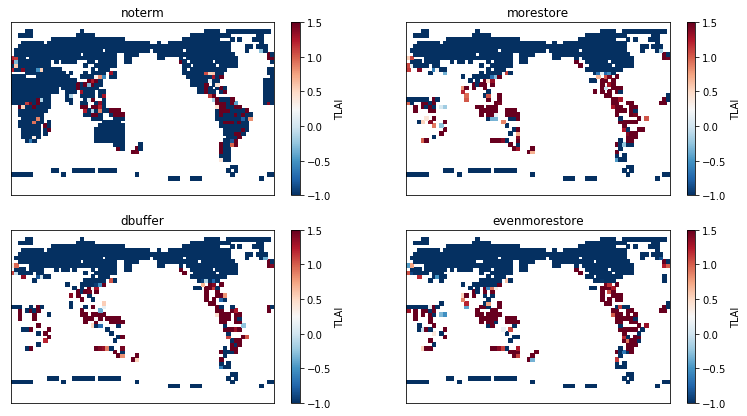

In [15]:
plt.rcParams['figure.figsize'] = [13, 7]
fig,([ax0, ax1],[ax2,ax3]) = plt.subplots(ncols=2, nrows=2)
t=ds4.SITE_COLD_STATUS.sizes['time']-365

plt1=np.log(ds4.TLAI.max(dim='time')).plot(ax=ax0)
plt2=np.log(ds5.TLAI.max(dim='time')).plot(ax=ax1)
plt3=np.log(ds6.TLAI.max(dim='time')).plot(ax=ax2)
plt4=np.log(ds7.TLAI.max(dim='time')).plot(ax=ax3)

ax0.set_title('noterm')
ax1.set_title('morestore')
ax2.set_title('dbuffer')
ax3.set_title('evenmorestore')

ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)

plt1.set_clim(-1, 1.5)
plt2.set_clim(-1, 1.5)
plt3.set_clim(-1, 1.5)
plt4.set_clim(-1, 1.5)


plt.savefig('../figs/DDT_maxTLAI.png')

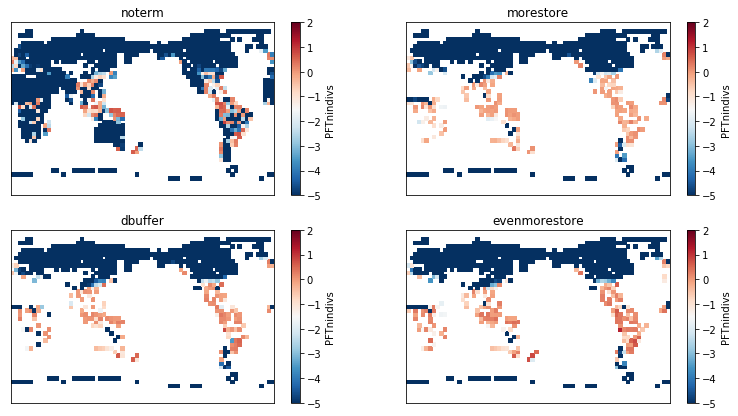

In [16]:
plt.rcParams['figure.figsize'] = [13, 7]
fig,([ax0, ax1],[ax2,ax3]) = plt.subplots(ncols=2, nrows=2)
t=ds4.SITE_COLD_STATUS.sizes['time']-365

plt1=np.log(ds4.PFTnindivs.max(dim='time')).plot(ax=ax0)
plt2=np.log(ds5.PFTnindivs.max(dim='time')).plot(ax=ax1)
plt3=np.log(ds6.PFTnindivs.max(dim='time')).plot(ax=ax2)
plt4=np.log(ds7.PFTnindivs.max(dim='time')).plot(ax=ax3)

ax0.set_title('noterm')
ax1.set_title('morestore')
ax2.set_title('dbuffer')
ax3.set_title('evenmorestore')

ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)

plt1.set_clim(-5, 2)
plt2.set_clim(-5, 2)
plt3.set_clim(-5, 2)
plt4.set_clim(-5, 2)


plt.savefig('../figs/DDT_maxN.png')

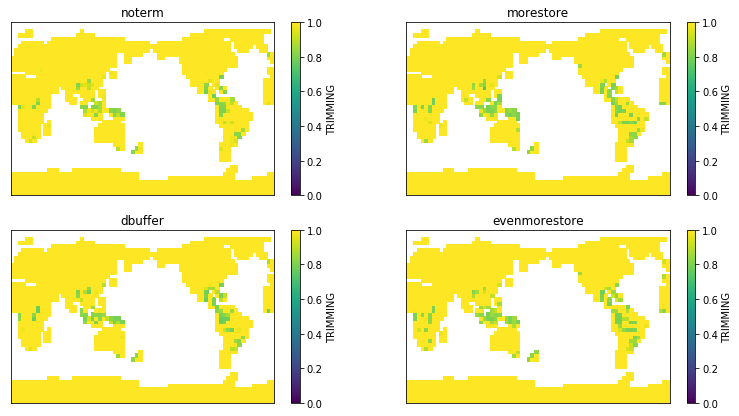

In [17]:
plt.rcParams['figure.figsize'] = [13, 7]
fig,([ax0, ax1],[ax2,ax3]) = plt.subplots(ncols=2, nrows=2)
t=ds4.SITE_COLD_STATUS.sizes['time']-365

plt1=ds4.TRIMMING.max(dim='time').plot(ax=ax0)
plt2=ds5.TRIMMING.max(dim='time').plot(ax=ax1)
plt3=ds6.TRIMMING.max(dim='time').plot(ax=ax2)
plt4=ds7.TRIMMING.max(dim='time').plot(ax=ax3)

ax0.set_title('noterm')
ax1.set_title('morestore')
ax2.set_title('dbuffer')
ax3.set_title('evenmorestore')

ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)

plt1.set_clim(0,1)
plt2.set_clim(0,1)
plt3.set_clim(0,1)
plt4.set_clim(0,1)


plt.savefig('../figs/DDT_trim.png')

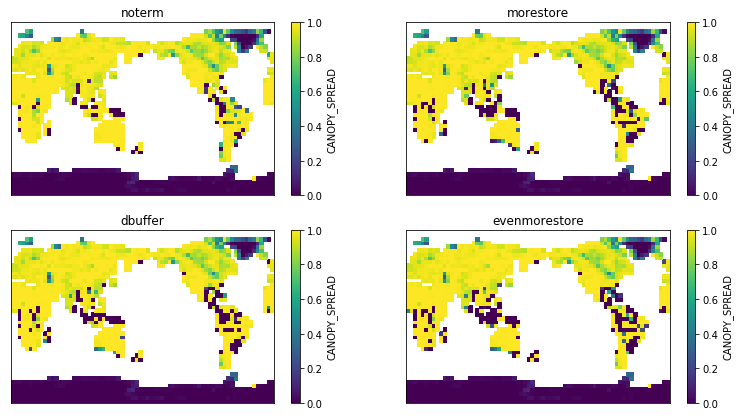

In [18]:
plt.rcParams['figure.figsize'] = [13, 7]
fig,([ax0, ax1],[ax2,ax3]) = plt.subplots(ncols=2, nrows=2)
t=ds4.SITE_COLD_STATUS.sizes['time']-365

plt1=ds4.CANOPY_SPREAD.max(dim='time').plot(ax=ax0)
plt2=ds5.CANOPY_SPREAD.max(dim='time').plot(ax=ax1)
plt3=ds6.CANOPY_SPREAD.max(dim='time').plot(ax=ax2)
plt4=ds7.CANOPY_SPREAD.max(dim='time').plot(ax=ax3)

ax0.set_title('noterm')
ax1.set_title('morestore')
ax2.set_title('dbuffer')
ax3.set_title('evenmorestore')

ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)

plt1.set_clim(0,1)
plt2.set_clim(0,1)
plt3.set_clim(0,1)
plt4.set_clim(0,1)


plt.savefig('../figs/DDT_spread.png')

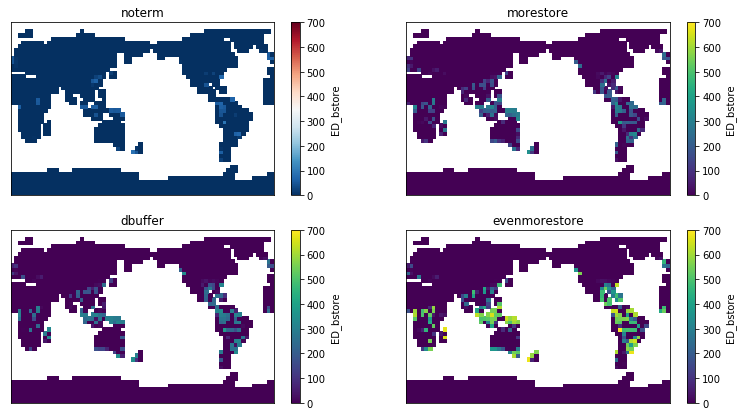

In [19]:
plt.rcParams['figure.figsize'] = [13, 7]
fig,([ax0, ax1],[ax2,ax3]) = plt.subplots(ncols=2, nrows=2)
t=ds4.SITE_COLD_STATUS.sizes['time']-1

plt1=ds4.ED_bstore.min(dim='time').plot(ax=ax0)
plt2=ds5.ED_bstore.min(dim='time').plot(ax=ax1)
plt3=ds6.ED_bstore.min(dim='time').plot(ax=ax2)
plt4=ds7.ED_bstore.min(dim='time').plot(ax=ax3)

ax0.set_title('noterm')
ax1.set_title('morestore')
ax2.set_title('dbuffer')
ax3.set_title('evenmorestore')

ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)

plt1.set_clim(0, 700)
plt2.set_clim(0, 700)
plt3.set_clim(0, 700)
plt4.set_clim(0, 700)


plt.savefig('../figs/DDT_maxbstore.png')

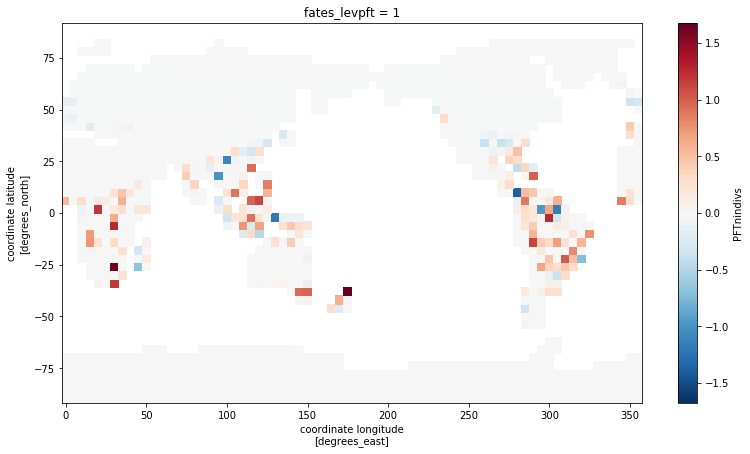

In [20]:
diff=ds7.PFTnindivs.max(dim='time')-ds6.PFTnindivs.max(dim='time')
diff.plot()

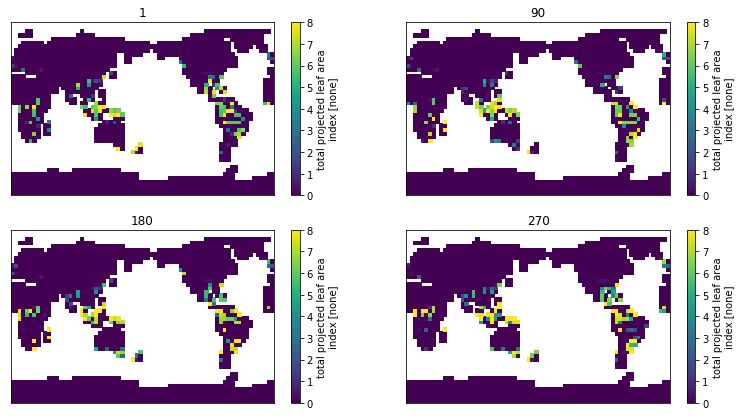

In [21]:
plt.rcParams['figure.figsize'] = [13, 7]
fig,([ax0, ax1],[ax2,ax3]) = plt.subplots(ncols=2, nrows=2)
t=ds4.SITE_COLD_STATUS.sizes['time']-365

plt1=ds7.TLAI[t+1,:,:].plot(ax=ax0)
plt2=ds7.TLAI[t+90,:,:].plot(ax=ax1)
plt3=ds7.TLAI[t+180,:,:].plot(ax=ax2)
plt4=ds7.TLAI[t+270,:,:].plot(ax=ax3)

ax0.set_title('1')
ax1.set_title('90')
ax2.set_title('180')
ax3.set_title('270')

ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)

plt1.set_clim(0, 8)
plt2.set_clim(0, 8)
plt3.set_clim(0, 8)
plt4.set_clim(0, 8)

plt.savefig('../figs/DDT_TLAI_dlo_evenmorestore_dbuffer.png')

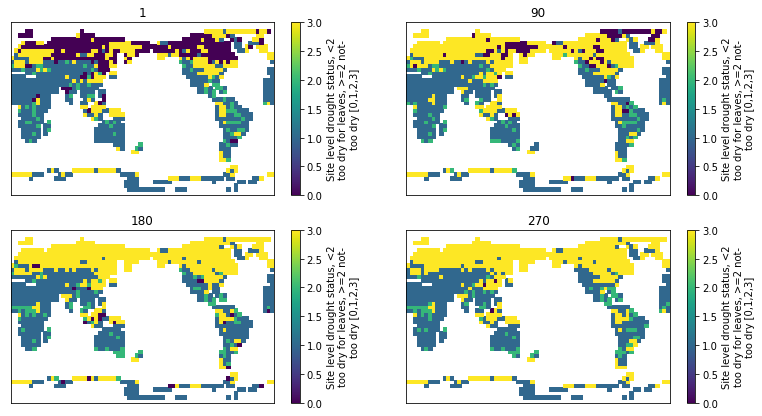

In [22]:
plt.rcParams['figure.figsize'] = [13, 7]
fig,([ax0, ax1],[ax2,ax3]) = plt.subplots(ncols=2, nrows=2)
t=ds4.SITE_COLD_STATUS.sizes['time']-365

plt1=ds7.SITE_DROUGHT_STATUS[t+1,:,:].plot(ax=ax0)
plt2=ds7.SITE_DROUGHT_STATUS[t+90,:,:].plot(ax=ax1)
plt3=ds7.SITE_DROUGHT_STATUS[t+180,:,:].plot(ax=ax2)
plt4=ds7.SITE_DROUGHT_STATUS[t+270,:,:].plot(ax=ax3)

ax0.set_title('1')
ax1.set_title('90')
ax2.set_title('180')
ax3.set_title('270')

ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)

plt1.set_clim(0, 3)
plt2.set_clim(0, 3)
plt3.set_clim(0, 3)
plt4.set_clim(0, 3)

plt.savefig('../figs/DDT_status_th0.25_dlo_evenmorestore.png')

In [ ]:
plt.rcParams['figure.figsize'] = [13, 7]
fig,([ax0, ax1],[ ax2, ax3]) = plt.subplots(ncols=2, nrows=2)
lats=range(19,22)
lons=range(1, 40)
print(ds0.lat[lats])

for l in lats:
   ds4.NPLANT_SCLS.isel(lat=l, lon=lons, fates_levscls=0).plot.line(ax=ax0,x='time',add_legend=False, marker='.')
   ds5.NPLANT_SCLS.isel(lat=l, lon=lons, fates_levscls=0).plot.line(ax=ax1,x='time',add_legend=False, marker='.')
   ds6.NPLANT_SCLS.isel(lat=l, lon=lons, fates_levscls=0).plot.line(ax=ax2,x='time',add_legend=False, marker='.')
   ds7.NPLANT_SCLS.isel(lat=l, lon=lons, fates_levscls=0).plot.line(ax=ax3,x='time',add_legend=False, marker='.')
plt.tight_layout()


ax0.set_title('noterm')
ax1.set_title('morestore')
ax2.set_title('dbuffer')
ax3.set_title('evenmorestore')

plt.savefig('../figs/DDT_site_nplants.png')

<xarray.DataArray 'lat' (lat: 3)>
array([-14., -10.,  -6.], dtype=float32)
Coordinates:
  * lat      (lat) float32 -14.0 -10.0 -6.0
Attributes:
    long_name:  coordinate latitude
    units:      degrees_north


In [ ]:
plt.rcParams['figure.figsize'] = [13, 7]
fig,([ax0, ax1],[ ax2, ax3]) = plt.subplots(ncols=2, nrows=2)
lats=range(19,22)
lons=range(1, 40)

for l in lats:
   np.log(ds6.MORTALITY_CANOPY_SCLS.isel(lat=l, lon=lons, fates_levscls=0)).plot.line(ax=ax0,x='time',add_legend=False, marker='.')
   np.log(ds6.MORTALITY_CANOPY_SCLS.isel(lat=l, lon=lons, fates_levscls=1)).plot.line(ax=ax1,x='time',add_legend=False, marker='.')
   np.log(ds7.MORTALITY_CANOPY_SCLS.isel(lat=l, lon=lons, fates_levscls=0)).plot.line(ax=ax2,x='time',add_legend=False, marker='.')
   np.log(ds7.MORTALITY_CANOPY_SCLS.isel(lat=l, lon=lons, fates_levscls=1)).plot.line(ax=ax3,x='time',add_legend=False, marker='.')
plt.tight_layout()


ax0.set_title('morestore-CL1')
ax1.set_title('morestoreN-CL2')

ax2.set_title('dbuffer-CL1')
ax3.set_title('dbuffer-CL2')

plt.savefig('../figs/mortality_ms.png')


In [ ]:
plt.rcParams['figure.figsize'] = [13, 7]
fig,([ax0, ax1],[ ax2, ax3]) = plt.subplots(ncols=2, nrows=2)
lats=range(19,22)
lons=range(1, 40)
print(ds0.lat[lats])
ymax=500
for l in lats:
   ymx=200
   ds6.PFTleafbiomass.isel(lat=l, lon=lons, fates_levpft=0).plot.line(ax=ax0,x='time',add_legend=False, marker='.',  ylim=(0,ymx))   
   ds7.PFTleafbiomass.isel(lat=l, lon=lons, fates_levpft=0).plot.line(ax=ax1,x='time',add_legend=False, marker='.', ylim=(0,ymx))
   ymx=800
   ds6.PFTstorebiomass.isel(lat=l, lon=lons, fates_levpft=0).plot.line(ax=ax2,x='time',add_legend=False, marker='.',  ylim=(0,ymx))
   ds7.PFTstorebiomass.isel(lat=l, lon=lons, fates_levpft=0).plot.line(ax=ax3,x='time',add_legend=False, marker='.',  ylim=(0,ymx))
plt.tight_layout()

ax0.set_title('morestore-lf')
ax1.set_title('dbuffer-lf')
ax2.set_title('morestore-st')
ax3.set_title('dbuffer-st')

plt.savefig('../figs/bstore_ms.png')

  From code: meaning of drought statuses...
  
  
  integer, parameter, public :: phen_dstat_timeoff   = 0       ! Leaves off due to time exceedance (drought phenology)                              
  integer, parameter, public :: phen_dstat_moistoff  = 1       ! Leaves off due to moisture avail  (drought phenology)                              
  integer, parameter, public :: phen_dstat_moiston   = 2       ! Leaves on due to moisture avail   (drought phenology)                              
  integer, parameter, public :: phen_dstat_timeon    = 3